Implementação do algoritmo apresentado por Grover no artigo "A fast quantum mechanical algorithm for database search”

Um banco de dados não ordenado contém 𝑁 registros, dos quais apenas um satisfaz uma determinada propriedade. O problema é identificar esse único registro. Qualquer algoritmo clássico, seja determinístico ou probabilístico, levará claramente 𝑂(𝑁) passos, já que, em média, precisará examinar uma grande fração dos 𝑁 registros.

Sistemas mecânicos quânticos podem realizar várias operações simultaneamente devido às suas propriedades ondulatórias. Este artigo apresenta um algoritmo quântico que encontra esse registro em $O(\sqrt{N})$ passos.

Este algoritmo está dentro de um fator constante do limite inferior teórico para a velocidade de qualquer algoritmo quântico que resolva esse problema.

Importação de bibliotecas e pacotes

In [1]:
%%capture
!pip install qiskit qiskit-aer qiskit_ibm_runtime qiskit-algorithms pyqubo

In [ ]:
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile, assemble
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit_aer import Aer, AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService, Session, SamplerV2 as Sampler, Estimator
from qiskit_ibm_runtime.fake_provider import FakeKyiv

In [21]:
n = 3  # número de qubits
oracle_target = '101'  # solução marcada

# 1. Inicialização
grover_circuit = QuantumCircuit(n, n)
grover_circuit.h(range(n))  # H⊗n para criar superposição uniforme

# 2. Oráculo
def apply_oracle(qc, target):
    for i, bit in enumerate(reversed(target)):
        if bit == '0':
            qc.x(i)
    qc.h(n-1)
    qc.mcx(list(range(n-1)), n-1)  # multi-controlled Z
    qc.h(n-1)
    for i, bit in enumerate(reversed(target)):
        if bit == '0':
            qc.x(i)

# 3. Difusor (amplificador)
def diffusion_operator(qc):
    qc.h(range(n))
    qc.x(range(n))
    qc.h(n-1)
    qc.mcx(list(range(n-1)), n-1)
    qc.h(n-1)
    qc.x(range(n))
    qc.h(range(n))

# Repetições (Grover iterations)
import math
num_iterations = int(math.floor((math.pi / 4) * math.sqrt(2**n)))

for _ in range(num_iterations):
    apply_oracle(grover_circuit, oracle_target)
    diffusion_operator(grover_circuit)

# 4. Medição
grover_circuit.measure(range(n), range(n))
grover_circuit.draw()

┌───┐          ┌───┐┌───┐               ┌───┐┌───┐               ┌───┐»
q_0: ┤ H ├───────■──┤ H ├┤ X ├────────────■──┤ X ├┤ H ├────────────■──┤ H ├»
     ├───┤┌───┐  │  ├───┤├───┤┌───┐       │  ├───┤├───┤┌───┐       │  ├───┤»
q_1: ┤ H ├┤ X ├──■──┤ X ├┤ H ├┤ X ├───────■──┤ X ├┤ H ├┤ X ├───────■──┤ X ├»
     ├───┤├───┤┌─┴─┐├───┤├───┤├───┤┌───┐┌─┴─┐├───┤├───┤├───┤┌───┐┌─┴─┐├───┤»
q_2: ┤ H ├┤ H ├┤ X ├┤ H ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ H ├┤ X ├┤ H ├»
     └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘»
c: 3/══════════════════════════════════════════════════════════════════════»
                                                                           »
«     ┌───┐               ┌───┐┌───┐     ┌─┐      
«q_0: ┤ X ├────────────■──┤ X ├┤ H ├─────┤M├──────
«     ├───┤┌───┐       │  ├───┤├───┤     └╥┘┌─┐   
«q_1: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────╫─┤M├───
«     ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐ ║ └╥┘┌─┐
«q_2: ┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├─╫──╫─┤M├
«     └───┘└───┘└───┘└───┘└───┘└───┘└───┘ ║  ║ └╥┘
«c: 3/════════════════════════════════════╩══╩══╩═
«                                         0  1  2

SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=1024, num_bits=3>)), metadata={'shots': 1024, 'circuit_metadata': {}})


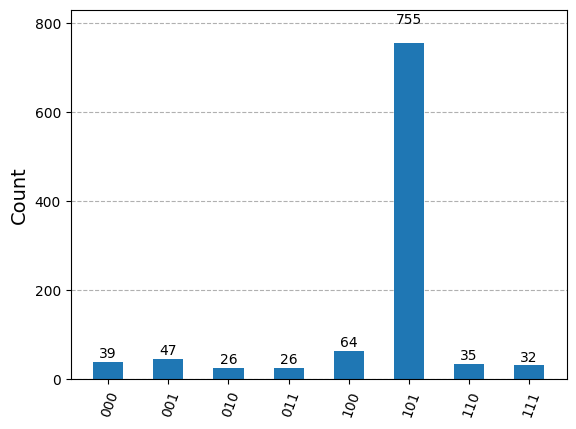

In [22]:
# Run the sampler job locally using FakeManilaV2
backend = FakeKyiv()

transpiled_circuit = transpile(grover_circuit, backend)
transpiled_circuit.draw()
sampler = Sampler(backend)
job = sampler.run([transpiled_circuit])
pub_result = job.result()[0]
print(pub_result)
counts = pub_result.data.c.get_counts()
plot_histogram(counts)